# Projet PRB222 : Options à Barrière

Question 3: Simuler W(T) a l'aide de Box Muller

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

from scipy.linalg import cholesky

from scipy.stats import norm

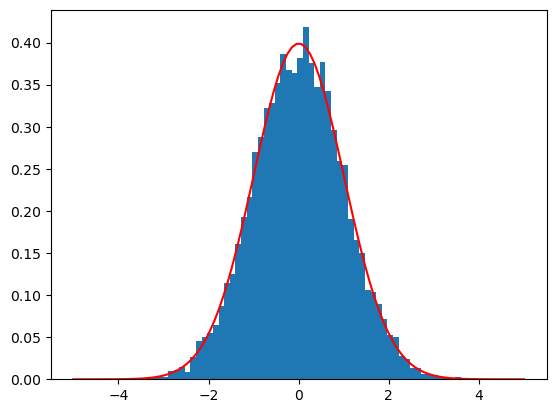

In [4]:


def box_muller(n):

  # n moitié de la taille de l'échantillon

  U=npr.random(n)
  V=npr.random(n)

  X=np.sqrt(-2*np.log(U))*np.cos(2*np.pi*V)
  Y=np.sqrt(-2*np.log(U))*np.sin(2*np.pi*V)

  return X,Y


n=5000
X,Y=box_muller(n)
Z=np.concatenate((X,Y))
plt.hist(Z,bins='auto', density= 'True')

x=np.linspace(-5,5,100)
plt.plot(x, norm.pdf(x),'r')

#norm.pdf c'est la fonction de densité de la loi normale standard

Implémentation du calcul de Peuro par une méthode de Monte Carlo classique

In [5]:
def montecarlo(Z):
  n=len(Z)
  somme=0
  for i in Z :
    somme=somme+i
  return somme/n

In [6]:

def p_euro(n,r,s0,sigma,T,K):

#On simule la variable brownienne ( Gaussienne ) W n fois (n scénarios différents)
  X,Y=box_muller(n)
  W=X
  ST=s0*np.exp((r-(sigma**2)/2)*T +sigma*np.sqrt(T)*W)

#On calcule le payoff actualisé: un vecteur ou les éléments sont nuls si négatifs, on a payoff=e-rT*(K - S(T))+

  payoff=np.exp(-r*T)*np.maximum(K-ST,0)

#Estimation de la variance de (K-S(T))+

  varpayoff=(n/(n-1))*(montecarlo(payoff**2)-montecarlo(payoff)**2)


#Intervalle de confiance

  a=1.645 #Fonction de répartition de la loi normale G telle que P(|G|<a)=0.9
  IC_min=montecarlo(payoff)- a*np.sqrt(varpayoff)/np.sqrt(len(payoff))
  IC_max=montecarlo(payoff)+a*np.sqrt(varpayoff)/np.sqrt(len(payoff))

#Calcul Prix avec la méthode de monte carlo
  P=montecarlo(payoff)


  return P,IC_min,IC_max












In [9]:

##VALEURS UTILISES
r=0.015
s0=1
sigma=0.15
T=2
K=1
#TEST1
P,IC_min,IC_max=p_euro(1000000,r,s0,sigma,T,K)
print("Le prix de l'option dans notre modèle pour un nombre d'itérations de 1000000 est:")
print(P)
print("L'intervalle de confiance de Peuro pour un nombre d'itérations de 1000000 est [",IC_min,",",IC_max,"]")

#Prix théorique

d1= (1 / (sigma*np.sqrt(T))) * (np.log(s0/K) + (r - (sigma ** 2) / 2) * T)
d2=d1+sigma*np.sqrt(T)
Pth=np.exp(-r*T)*K*norm.cdf(-d1)- s0*norm.cdf(-d2)
print("Le prix théorique est",Pth)


# On trace en fonction du nombre d'itération Peuro et l'intervalle de confiance
N=1000000
pas=10000
P_euro=np.zeros(int(N/pas))
IC_min_e=np.zeros(int(N/pas))
IC_max_e=np.zeros(int(N/pas))
j=0
for i in range(2,N,pas):
  P,IC_min,IC_max=p_euro(i,r,s0,sigma,T,K)
  P_euro[j]=P
  IC_min_e[j]=IC_min
  IC_max_e[j]=IC_max
  j=j+1


Le prix de l'option dans notre modèle pour un nombre d'itérations de 1000000 est:
0.06914991140106304
L'intervalle de confiance de Peuro pour un nombre d'itérations de 1000000 est [ 0.06898718288782989 , 0.06931263991429619 ]
Le prix théorique est 0.06927220525436278


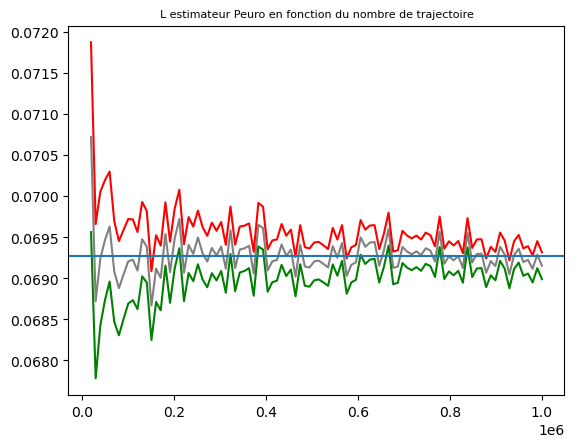

In [8]:
X=np.linspace(1,N,int(N/pas))
plt.plot(X[2:], P_euro[2:], color='grey')
plt.plot(X[2:],IC_max_e[2:], color='red')
plt.plot(X[2:],IC_min_e[2:],color='green')
plt.title('L estimateur Peuro en fonction du nombre de trajectoire', fontsize=8)
plt.axhline(y=Pth);

Option Barrière DOWN & OUT


In [10]:
def mvt_brownien(T,delta):
  n=int(T//delta)               #trajectoire brownienne de longueur n

  Gamma=np.zeros((n,n))

  time_grid = np.linspace(delta,T,n)

  Gamma = np.tile(time_grid, (n, 1))

  Gamma = np.tril(Gamma)

  Gamma = Gamma + Gamma.T - np.diag(np.diag(Gamma))

  G,Y=box_muller(n)
  A=cholesky(Gamma)

  W=np.concatenate((0*np.ones(1),np.dot(A.T,G)))

  return W

1ere méthode : boucle

In [43]:


def Pdo(S0,K,T,r,sigma, delta,n, B):
  N=int(T//delta)
  S=np.ones((n,N))
  for i in range (n):  #on simule n trajectoires de taille T//delta  K - S(T)
     W = mvt_brownien(T,delta)
     for j in range (N):
        S[i,j]=s0*np.exp((r-(sigma**2)/2)*j*delta +sigma*W[j])

  indic=(np.min(S,axis=1)>=B)     #Indicatrice
  payoff=np.exp(-r*T)*np.maximum(K-S[:,-1], 0)*indic


  Prix_MC=montecarlo(payoff)
  #Estimation de la variance du payoff

  varpayoff=(n/(n-1))*(montecarlo(payoff**2)-montecarlo(payoff)**2)

  a=1.29 #Fonction de répartition de la loi normale G telle que P(|G|<a)=0.9
  IC_min=Prix_MC- a*np.sqrt(varpayoff)/np.sqrt(n)
  IC_max= Prix_MC+a*np.sqrt(varpayoff)/np.sqrt(n)


  return Prix_MC, IC_min, IC_max





2ème méthode : Passage au log

In [ ]:
def Pdo_log(S0,K,T,r,sigma, step,n, B):

  N=int(T//step)
  Z=np.zeros((n,N))
  W=np.zeros((n,N+1))

  for i in range (n):  #on simule n trajectoires de taille T//delta   S(T)
     W[i,:] = mvt_brownien(T,step)

  Log_returns=(r-sigma**2/2)*step*np.ones((n,N))

  Log_paths=np.concatenate((np.log(S0)*np.ones((n,1)),Log_returns), axis=1)

  Log_Spaths=np.cumsum(Log_paths,axis=1) +sigma*W

  Spaths=np.exp(Log_Spaths)

  indic=(np.min(Spaths,axis=1)>=B)

  payoff=np.exp(-r*T)*np.maximum(K-Spaths[:,-1],0)*indic

  Prix_MC=montecarlo(payoff)

  #Estimation de la variance du payoff

  varpayoff=(n/(n-1))*(montecarlo(payoff**2)-montecarlo(payoff)**2)

  a=1.29 #Fonction de répartition de la loi normale G telle que P(|G|<a)=0.9
  IC_min=Prix_MC- a*np.sqrt(varpayoff)/np.sqrt(n)
  IC_max= Prix_MC+a*np.sqrt(varpayoff)/np.sqrt(n)


  return Prix_MC, IC_min, IC_max

Cette méthode est deux fois plus rapide

In [44]:
##VALEURS UTILISES
r=0.015
s0=1
sigma=0.15
T=2
K=1
delta=1/52
B=0.7
n=10000
#TEST1
P,IC_min,IC_max=Pdo(s0,K,T,r,sigma, delta,n, B)

print("Le prix de l'option dans notre modèle pour un nombre d'itérations de",n,"est:")
print(P)

N=10000
pas=100
P_euro=np.zeros(int(N/pas))
IC_min_e=np.zeros(int(N/pas))
IC_max_e=np.zeros(int(N/pas))
j=0
for i in range(2,N,pas):
  #P,IC_min,IC_max=Pdo(s0,K,T,r,sigma, delta,i, B)
  P,IC_min,IC_max=Pdo_log(s0,K,T,r,sigma, delta,i, B)
  P_euro[j]=P
  IC_min_e[j]=IC_min
  IC_max_e[j]=IC_max
  j=j+1



Le prix de l'option dans notre modèle pour un nombre d'itérations de 10000 est:
0.04720312769927029


Text(0, 0.5, 'Prix de l option de vente')

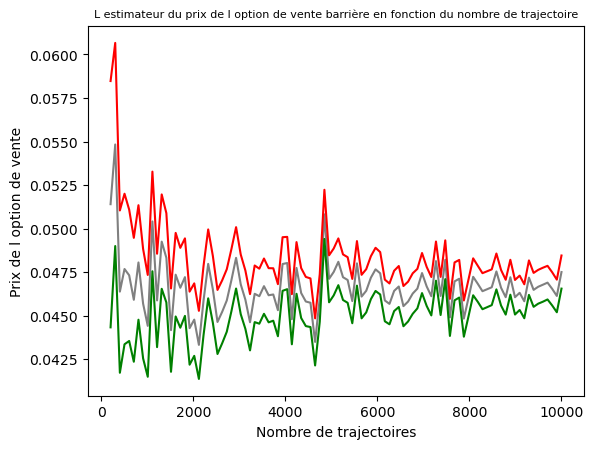

In [48]:
X=np.linspace(1,N,int(N/pas))

plt.plot(X[2:], P_euro[2:], color='grey')
plt.plot(X[2:],IC_max_e[2:], color='red')
plt.plot(X[2:],IC_min_e[2:],color='green')
plt.title('L estimateur du prix de l option de vente barrière en fonction du nombre de trajectoire', fontsize=8)
plt.xlabel('Nombre de trajectoires')
plt.ylabel('Prix de l option de vente')


Méthode des variables antithétiques

Version 1

In [106]:
def P_antith(n, r, s0, sigma, T, K, delta,B):

  N=int(T//delta)
  S=np.ones((n,N))
  Sa=np.ones((n,N))
  for i in range (n):  #on simule n trajectoires de taille T//delta  K - S(T)
     W = mvt_brownien(T,delta)
     for j in range (N):
        S[i,j]=s0*np.exp((r-(sigma**2)/2)*j*delta +sigma*W[j])
        Sa[i,j]=s0*np.exp((r-(sigma**2)/2)*j*delta +sigma*(-W[j]) )

   #On modifie Z en un vecteur ou les éléments sont nuls si négatifs ou S(u)<B


  indic=(np.min(S,axis=1)>=B)     #Indicatrice
  indica=(np.min(Sa,axis=1)>=B)

  payoffa=0.5*np.exp(-r*T)*( np.maximum(K-Sa[:,-1], 0)*indica+np.maximum(K-S[:,-1], 0)*indic) #Méthode antithétiue

 
  Prix_antith=montecarlo(payoffa)
  
  

  a=1.29 #Fonction de répartition de la loi normale G telle que P(|G|<a)=0.9
  
  IC_min_a=Prix_antith-a*np.std(payoffa)/np.sqrt(n)
  IC_max_a=Prix_antith+a*np.std(payoffa)/np.sqrt(n)

  
  return Prix_antith,IC_min_a,IC_max_a

In [108]:


def P_antith_comp(n, r, s0, sigma, T, K, delta,B):

  N=int(T//delta)
  S=np.ones((n,N))
  Sa=np.ones((n,N))
  for i in range (n):  #on simule n trajectoires de taille T//delta  K - S(T)
     W = mvt_brownien(T,delta)
     for j in range (N):
        S[i,j]=s0*np.exp((r-(sigma**2)/2)*j*delta +sigma*W[j])
        Sa[i,j]=s0*np.exp((r-(sigma**2)/2)*j*delta +sigma*(-W[j]) )

   #On modifie Z en un vecteur ou les éléments sont nuls si négatifs ou S(u)<B


  indic=(np.min(S,axis=1)>=B)     #Indicatrice
  indica=(np.min(Sa,axis=1)>=B)
  payoff = np.exp(-r*T)*np.maximum(K-S[:,-1], 0)*indic   #Méthode classique
  payoffa=0.5*np.exp(-r*T)*( np.maximum(K-Sa[:,-1], 0)*indica+np.maximum(K-S[:,-1], 0)*indic) #Méthode antithétiue

  Prix=montecarlo(payoff)
  Prix_antith=montecarlo(payoffa)
  
  

  a=1.29 #Fonction de répartition de la loi normale G telle que P(|G|<a)=0.9
  IC_min=Prix- a*np.std(payoff)/np.sqrt(n)
  IC_max= Prix+a*np.std(payoff)/np.sqrt(n)
  IC_min_a=Prix_antith-a*np.std(payoffa)/np.sqrt(n)
  IC_max_a=Prix_antith+a*np.std(payoffa)/np.sqrt(n)

  
  return Prix_antith,IC_min,IC_max,Prix,IC_min_a,IC_max_a





In [109]:


r=0.015
s0=1
sigma=0.15
T=2
K=1
delta=1/52
B=0.7
n=10000
P,IC_min,IC_max=P_antith(n, r, s0, sigma, T, K, delta,B)

print("Le prix de l'option dans notre modèle pour un nombre d'itérations de",n,"est:")
print(P)


N=10000
pas=100
IC_min_e=np.zeros(int(N/pas))
IC_max_e=np.zeros(int(N/pas))
IC_mina=np.zeros(int(N/pas))
IC_maxa=np.zeros(int(N/pas))
P=np.zeros(int(N/pas))
P_ant=np.zeros(int(N/pas))
j=0
for i in range(2,N,pas):
  Prix_antith,IC_min,IC_max,Prix,IC_min_a,IC_max_a=P_antith_comp(i, r, s0, sigma, T, K, delta,B)
  P[j]=Prix
  IC_min_e[j]=IC_min
  IC_max_e[j]=IC_max
  P_ant[j]=Prix_antith
  IC_mina[j]=IC_min_a
  IC_maxa[j]=IC_max_a
  j=j+1


X=np.linspace(1,N,int(N/pas))


Le prix de l'option dans notre modèle pour un nombre d'itérations de 10000 est:
0.04704408138551177


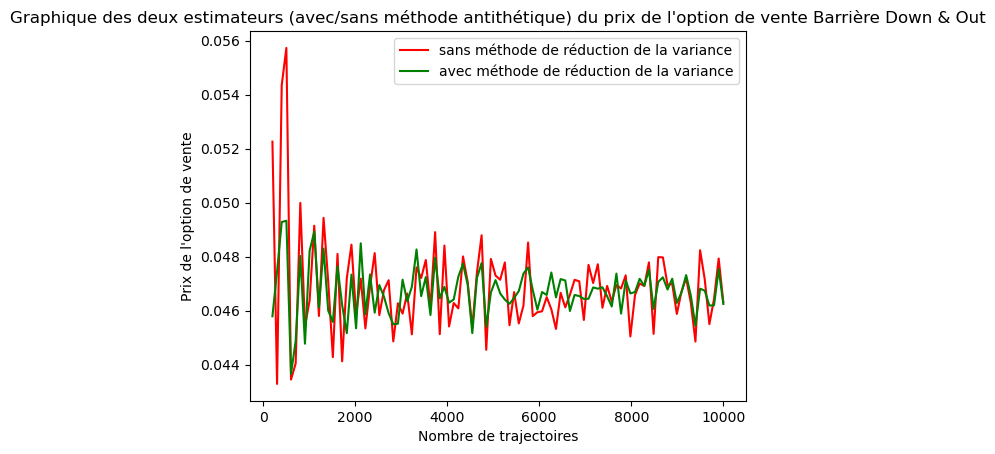

In [110]:
plt.plot(X[2:], P[2:], color='red',label='sans méthode de réduction de la variance')


plt.plot(X[2:], P_ant[2:], color='green',label='avec méthode de réduction de la variance')

plt.title("Graphique des deux estimateurs (avec/sans méthode antithétique) du prix de l'option de vente Barrière Down & Out")
plt.xlabel("Nombre de trajectoires")
plt.ylabel("Prix de l'option de vente")
plt.legend()

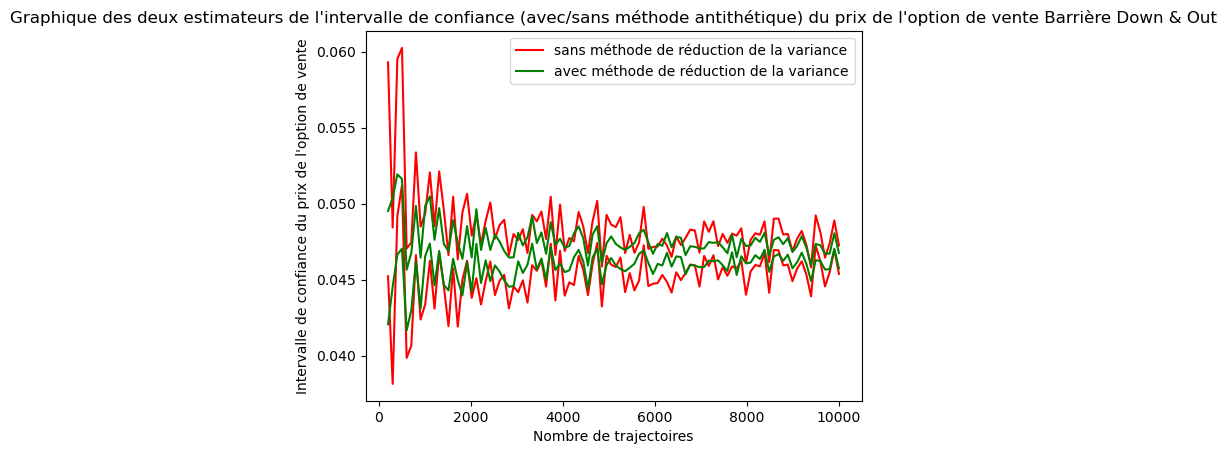

In [111]:
plt.plot(X[2:],IC_max_e[2:], color='red',label='sans méthode de réduction de la variance')
plt.plot(X[2:],IC_min_e[2:],color='red')
plt.plot(X[2:],IC_maxa[2:], color='green',label='avec méthode de réduction de la variance')
plt.plot(X[2:],IC_mina[2:],color='green')
plt.title("Graphique des deux estimateurs de l'intervalle de confiance (avec/sans méthode antithétique) du prix de l'option de vente Barrière Down & Out")
plt.xlabel("Nombre de trajectoires")
plt.ylabel("Intervalle de confiance du prix de l'option de vente")
plt.legend()

# Pour B appartenant à [0.5,1]

In [42]:
r=0.015
s0=1
sigma=0.15
T=2
K=1
delta=1/52

n=10000
i=0
P_t=np.zeros(50)
B_l=np.linspace(0.5,1,50)
for B in B_l:
    Prix_antith,IC_min,IC_max=P_antith(n, r, s0, sigma, T, K, delta,B)
    P_t[i]=Prix_antith
    i=i+1



Text(0.5, 1.0, 'Prix de l option de vente en fonction de la barrière B')

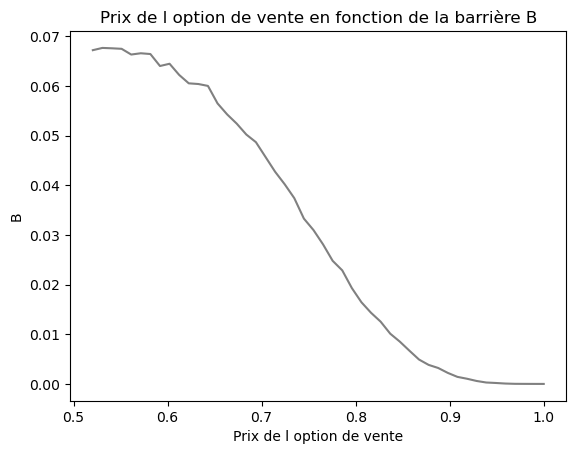

In [41]:
plt.plot(B_l[2:], P_t[2:], color='grey')
plt.xlabel('Prix de l option de vente')
plt.ylabel('B')
plt.title('Prix de l option de vente en fonction de la barrière B pour n=10000')

# P en fonction de sigma appartenant à [0,0.8]

In [93]:
r=0.015

B=0.7
T=2
K=1
delta=1/52

n=100000
i=0
P_sigma1=np.zeros(50)
P_sigma2=np.zeros(50)
sigma_l=np.linspace(0,0.8,50)
for sigma in sigma_l:
    Prix_antith,IC_min,IC_max=P_antith_v2(n, r, 1, sigma, T, K, delta,B)
    P_sigma1[i]=Prix_antith
    Prix_antith,IC_min,IC_max=P_antith_v2(n, r, 0.8, sigma, T, K, delta,B)
    P_sigma2[i]=Prix_antith
    i=i+1


Text(0, 0.5, "Prix de l'option barrière")

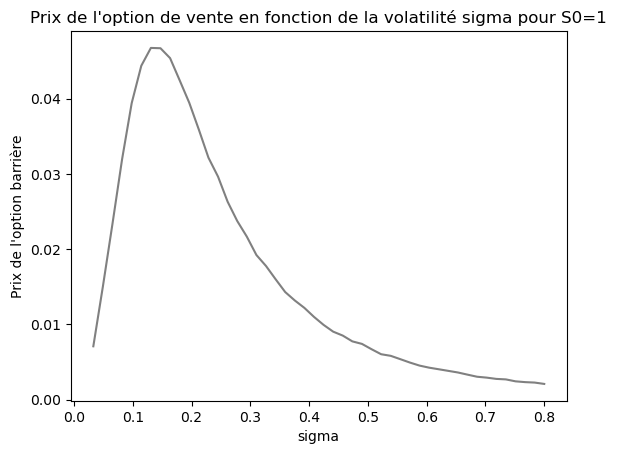

In [94]:
plt.plot(sigma_l[2:], P_sigma1[2:], color='grey')
plt.title("Prix de l'option de vente en fonction de la volatilité sigma pour S0=1")
plt.xlabel("sigma")
plt.ylabel("Prix de l'option barrière")

Text(0, 0.5, "Prix de l'option barrière")

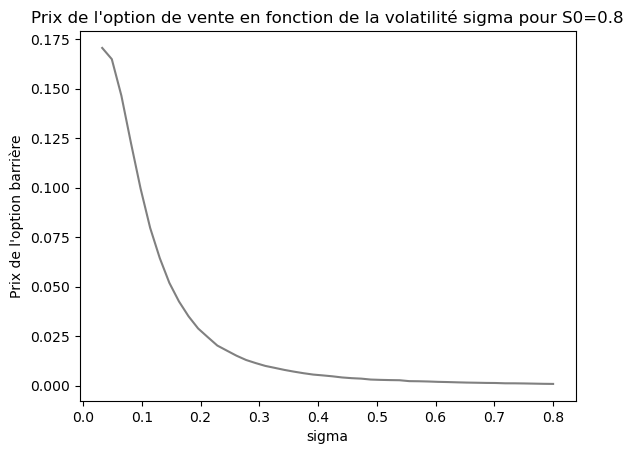

In [95]:
plt.plot(sigma_l[2:], P_sigma2[2:], color='grey')
plt.title("Prix de l'option de vente en fonction de la volatilité sigma pour S0=0.8")
plt.xlabel("sigma")
plt.ylabel("Prix de l'option barrière")

Approximation de P_{do} à partir de P_{do,delta}


In [ ]:
def P_d0_exacte(n, r, s0, sigma, T, K, delta, B):
    N = int(T // delta)
    Z = np.zeros(n)
    S_t = 0
    for i in range(n):  # on simule n trajectoires de taille T//delta  K - S(T)
        W = mvt_brownien(T, delta)
        # Initialise la probabilité pour cette trajectoire
        proba = 1
        option_valide=0      # Cette variable nous sert à détecter si St est passé en dessous de B, car dans ce cas, le prix vaut automatiquement 0 car l'option ne peut pas être éxercée
        for j in range(1, N):
            S_t = s0 * np.exp((r - (sigma ** 2) / 2) * j * delta + (sigma * W[j]))
            S_t_prev = s0 * np.exp((r - (sigma ** 2) / 2) * (j - 1) * delta + (sigma * W[j - 1]))
            # Calcule la probabilité conditionnelle que S_t reste au-dessus de B
            x_prime = (1/sigma)*(np.log(B/s0)+((0.5*(sigma**2)-r)*((j)*delta)))
            if  W[j]> x_prime and W[j-1] > x_prime:
                x = B
                t1 = (j - 1) * delta
                t2 = j * delta
                proba *= 1-np.exp((-2*(W[j]-x_prime)*(W[j-1]-x_prime)) / (t2-t1))   #On réalise le produit des probabilités
            if W[j]< x_prime or W[j-1] < x_prime:
                proba*=0
                option_valide=1
        if option_valide ==1 :
            Z[i]=0
        else :
            Z[i] = np.exp(-r * T) *max(K - S_t, 0)*proba  # Payoff à l'échéance si S_t > B
        #Z[i][-1] *= proba  # On ne garde que les payoffs des trajectoires qui restent au-dessus de B

    P = montecarlo(Z)

    a=1.29 #Fonction de répartition de la loi normale G telle que P(|G|<a)=0.9
    IC_min=P- a*np.std(Z)/np.sqrt(n)
    IC_max= P+a*np.std(Z)/np.sqrt(n)
    return P, IC_min, IC_max


In [ ]:
##VALEURS UTILISES
r=0.015
s0=1
sigma=0.15
T=2
K=1
delta=1/500
B=0.7
n=15000
#TEST1
P=1
P=P_d0_exacte(n, r, s0, sigma, T, K, delta, B)[0]
print("Le prix de l'option dans notre modèle pour un nombre d'itérations de",n,"est:")
print(P)

Le prix de l'option dans notre modèle pour un nombre d'itérations de 15000 est:
0.04417580130953318


In [ ]:
# Simulation de l'évolution du prix en fonction du nombre de trajectoires
r=0.015
s0=1
sigma=0.15
T=2
K=1
delta=1/52
B=0.7
n=30000
pas = 100

P_euro=np.zeros(int(n/pas))
IC_min_e=np.zeros(int(n/pas))
IC_max_e=np.zeros(int(n/pas))
j=0
for i in range(2,n,pas):
  P,IC_min,IC_max=P_d0_exacte(i, r, s0, sigma, T, K, delta, B)
  P_euro[j]=P
  IC_min_e[j]=IC_min
  IC_max_e[j]=IC_max
  j=j+1

X=np.linspace(1,n,int(n/pas))

plt.plot(X[2:], P_euro[2:], color='blue')
plt.plot(X[2:],IC_max_e[2:], color='red')
plt.plot(X[2:],IC_min_e[2:],color='green')
plt.xlabel('Nombre de trajectoires')
plt.ylabel('Prix de l\'option')
plt.title('Prix de l\'option en fonction du nombre de trajectoires')
plt.grid(True)

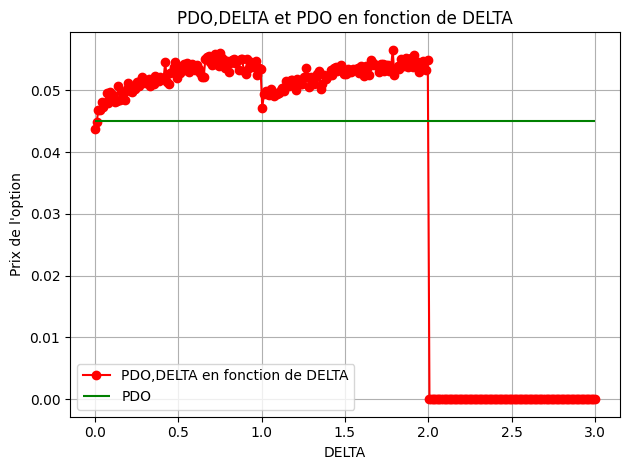

In [ ]:
# Calcul des prix pour différentes valeurs de Delta
r=0.015
s0=1
sigma=0.15
T=2
K=1
delta=1/52
B=0.7
n=5000
#delta_values_fine = [1/250,1/52,1/12,1/4,1,3]
delta_values_fine = np.linspace(0.001,3,300)
prices_delta_fine = np.zeros(300)
i=0
P_euro = 1
for j in delta_values_fine:
  P_euro=P_antith_v2(n, r, s0, sigma, T, K, j,B)[0]
  prices_delta_fine[i]=P_euro
  i+=1

#prices_delta_fine = [Pdo(s0,K,T,r,sigma,j,n, B,1)[0] for j in delta_values_fine]

# Tracé du second graphique avec plus de valeurs de Delta
plt.plot(delta_values_fine, prices_delta_fine, 'o-r', label='PDO,DELTA en fonction de DELTA')
pdo_price = P
plt.hlines(pdo_price, min(delta_values_fine), max(delta_values_fine), colors='green', label='PDO')
plt.xlabel('DELTA')
plt.ylabel('Prix de l\'option')
plt.title('PDO,DELTA et PDO en fonction de DELTA')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Calcul des probabilités de non-sortie

In [ ]:
##Cette fonction va calculer la probabilité de non-sortie en fonction de delta
def P_antith_non_probabilite_v2(N, r, S0, sigma, T, delta,B):
  n=int(T//delta)

  W=np.zeros((N//2,n+1))
  Wa=np.zeros((N//2,n+1))
  for i in range (N//2):  #on simule N trajectoires de taille T//delta  K - S(T)
     W[i,:] = mvt_brownien(T,delta)
  Wa=-W

  Log_returns=(r-sigma**2/2)*delta*np.ones((N//2,n))

  Log_paths=np.concatenate((np.log(S0)*np.ones((N//2,1)),Log_returns), axis=1)

  Log_Spaths_1=np.cumsum(Log_paths,axis=1) + sigma*W
  Log_Spaths_2=np.cumsum(Log_paths,axis=1) + sigma*Wa


  Spaths_1=np.exp(Log_Spaths_1)
  Spaths_2=np.exp(Log_Spaths_2)


  indic1=(np.min(Spaths_1,axis=1)>=B)
  indic2=(np.min(Spaths_2,axis=1)>=B)
  payoff1=np.exp(-r*T)*indic1
  payoff2=np.exp(-r*T)*indic2
  Prix_antith=estim_antith(payoff1,payoff2)

  a=1.29 #Fonction de répartition de la loi normale G telle que P(|G|<a)=0.9
  IC_min=Prix_antith- a*np.std(payoff1+payoff2)/np.sqrt(N//2)
  IC_max= Prix_antith+a*np.std(payoff1+payoff2)/np.sqrt(N//2)
  return Prix_antith,IC_min,IC_max

In [ ]:
def Pdo_exact_non_probabilite(n, r, s0, sigma, T, delta, B):
    N = int(T // delta)
    Z = np.zeros(n)
    S_t = 0
    for i in range(n):  # on simule n trajectoires de taille T//delta  K - S(T)
        W = mvt_brownien(T, delta)
        # Initialise la probabilité pour cette trajectoire
        proba = 1
        option_valide=0      # Cette variable nous sert à détecter si St est passé en dessous de B, car dans ce cas, le prix vaut automatiquement 0 car l'option ne peut pas être éxercée
        for j in range(1, N):
            S_t = s0 * np.exp((r - (sigma ** 2) / 2) * j * delta + (sigma * W[j]))
            # Calcule la probabilité conditionnelle que S_t reste au-dessus de B
            x_prime = (1/sigma)*(np.log(B/s0)+((0.5*(sigma**2)-r)*((j)*delta)))
            if  W[j]> x_prime and W[j-1] > x_prime:
                x = B
                t1 = (j - 1) * delta
                t2 = j * delta
                proba *= 1-np.exp((-2*(W[j]-x_prime)*(W[j-1]-x_prime)) / (t2-t1))   #On réalise le produit des probabilités
            if W[j]< x_prime or W[j-1] < x_prime:
                proba*=0
                option_valide=1
        if option_valide ==1 :
            Z[i]=0
        else :
            Z[i] = proba  # Payoff à l'échéance si S_t > B
        #Z[i][-1] *= proba  # On ne garde que les payoffs des trajectoires qui restent au-dessus de B

    E = montecarlo(Z)
    P = np.exp(-r * T) * E
    return P


La valeur de la probabilité de non-sortie dans notre modèle pour un nombre d'itérations de 5000 est:
0.8850124812624418


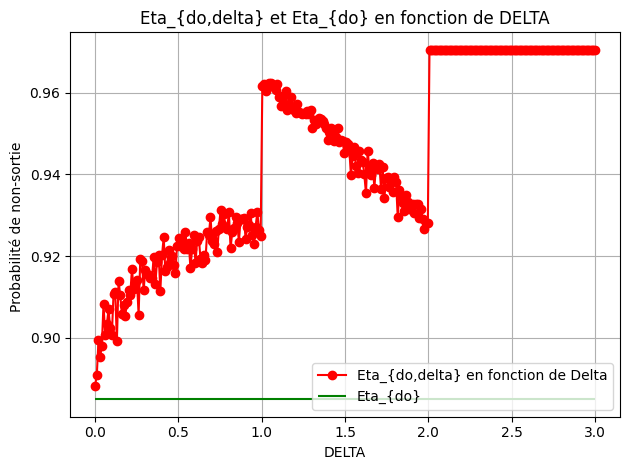

In [ ]:
## Valeurs utilisées
r=0.015
s0=1
sigma=0.15
T=2
K=1
delta=1/52
B=0.7
n=5000
# Calcul de la probabilité exatce de non-sortie indépendante
Eta=Pdo_exact_non_probabilite(n, r, s0, sigma, T, delta, B)
print("La valeur de la probabilité de non-sortie dans notre modèle pour un nombre d'itérations de",n,"est:")
print(Eta)
# Calcul des prix pour différentes valeurs de Delta
#delta_values_fine = [1/250,1/200,1/100,1/52,1/25,1/12,1/4,1,1.5,2,3]

delta_values_fine = np.linspace(0.001,3,300)
prices_delta_fine = np.zeros(300)

i=0
P_euro=1
for j in delta_values_fine:
  P_euro=P_antith_non_probabilite_v2(n, r, s0, sigma, T, j,B)[0]
  prices_delta_fine[i]=P_euro
  i+=1


# Tracé du second graphique avec plus de valeurs de Delta
plt.plot(delta_values_fine, prices_delta_fine, 'o-r', label='Eta_{do,delta} en fonction de Delta')
Eta_do = Eta
plt.hlines(Eta_do, min(delta_values_fine), max(delta_values_fine), colors='green', label='Eta_{do}')
plt.xlabel('DELTA')
plt.ylabel('Probabilité de non-sortie ')
plt.title('Eta_{do,delta} et Eta_{do} en fonction de DELTA')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Tracé de la probabilité de non-sortie en fonction de B

Text(0.5, 1.0, 'Probabilité de non-sortie en fonction de la barrière B')

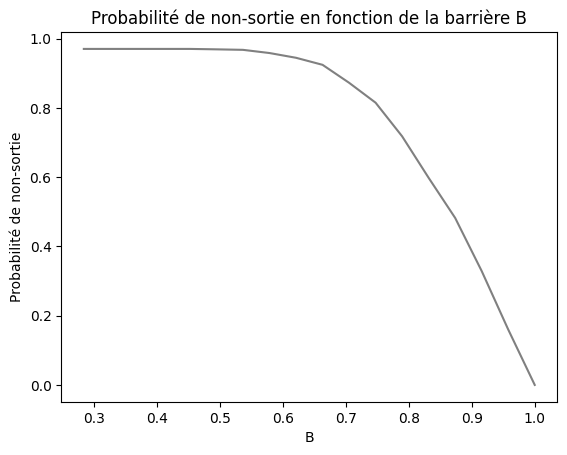

In [ ]:
r=0.015
s0=1
sigma=0.15
T=2
K=1
delta=1/52

n=3000
i=0
P_t=np.zeros(20)
B_l=np.linspace(0.2,1,20)
for B in B_l:
    Prix_antith=Pdo_exact_non_probabilite(n, r, s0, sigma, T, delta,B)
    P_t[i]=Prix_antith
    i=i+1
plt.plot(B_l[2:], P_t[2:], color='grey')
plt.ylabel('Probabilité de non-sortie')
plt.xlabel('B')
plt.title('Probabilité de non-sortie en fonction de la barrière B')